In [65]:
# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(font_scale=2, style="white")

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.patches as mpatches
# set plotting size parameter
plt.rcParams['figure.figsize'] = (17, 7)

# import pandas & numpy library
import pandas as pd
import numpy as np

# Statmodels & patsy
import patsy
import statsmodels.api as sm

import re
import csv

Clean Data

In [2]:
data = pd.read_csv('164_data.csv')
data

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,SC0,SC1,SC2,SC3,SC4,SC5,SC6,SC7,KeyResponses,PlayerScore
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,Score,PSS,Worry,SIMS,IM,IR,ER,AM,KeyResponses,PlayerScore
1,3/7/25 15:06,3/7/25 15:22,IP Address,104.28.123.69,100,958,True,3/7/25 15:22,R_5mfKUow7U5keLqB,NaN,...,87,13,31,43,13,10,4,16,NaN,750
2,3/7/25 15:52,3/7/25 15:56,IP Address,128.54.150.42,100,236,True,3/7/25 15:56,R_7aC5E4t2ycalPnX,NaN,...,116,28,33,55,19,10,16,10,NaN,0
3,3/7/25 17:40,3/7/25 17:48,IP Address,128.54.149.140,100,513,True,3/7/25 17:48,R_5iuDcNhOfrT5RkZ,NaN,...,88,10,14,64,28,10,16,10,i,600
4,3/8/25 00:01,3/8/25 00:15,IP Address,128.54.167.194,100,840,True,3/8/25 00:15,R_6ABoXkf9sOwPCGB,NaN,...,122,18,37,67,19,16,13,19,NaN,1050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,3/13/25 14:09,3/13/25 14:30,IP Address,204.75.250.11,100,1274,True,3/13/25 14:30,R_61drB8KG3XlsLpO,NaN,...,115,19,38,58,25,13,4,16,NaN,650
104,3/13/25 15:17,3/13/25 15:22,IP Address,128.54.31.88,100,317,True,3/13/25 15:22,R_3dVV48c2Rhl1QEm,NaN,...,106,40,50,16,4,4,4,4,"i,i,u,i,u",0
105,3/13/25 15:31,3/13/25 15:43,IP Address,137.110.103.47,100,723,True,3/13/25 15:43,R_6SIi1YhAiosITiU,NaN,...,107,20,26,61,25,10,13,13,i,650
106,3/13/25 16:57,3/13/25 16:59,IP Address,69.196.47.60,100,168,True,3/13/25 16:59,R_3iO1saaSLmNB1DP,NaN,...,104,18,28,58,25,13,13,7,NaN,0


In [3]:


# Drop and rename columns
data = data.drop(labels = ['EndDate', 'SC0', 'SC3', 'Duration (in seconds)', 'Status', 'IPAddress', 'Progress', 
        'Finished', 'RecordedDate', 'ResponseId',
        'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
        'ExternalReference', 'LocationLatitude', 'LocationLongitude',
        'DistributionChannel', 'UserLanguage', 'Q9',
        'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q20',
        'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29',
        'Q32_1', 'Q32_2', 'Q32_3',
        'Q32_4', 'Q32_5', 'Q32_6', 'Q32_7', 'Q32_8', 'Q32_9', 'Q32_10',
        'Q32_11', 'Q32_12', 'Q32_13', 'Q32_14', 'Q32_15', 'Q32_16'], axis=1)

data.columns = ['StartDate', 'Q_Eat', 'Q_Sleep', 'Q_Comfort', 'Q_Exercise',
       'C_First Click', 'C_Last Click', 'C_Page Submit',
       'C_Click Count', 'E_First Click', 'E_Last Click',
       'E_Page Submit', 'E_Click Count',
       'Q_Age', 'Q_Gender', 'Q_Ethn', 'Q_Income', 'Q_FinSec', 'PSS',
       'Worry', 'IM', 'IR', 'ER', 'AM', 'KeyResponses', 'PlayerScore']

data = data.iloc[1:]

# Add column describing experimental/control group
data = data.assign(Group= data['C_Page Submit'].isna().apply(lambda x: 'Experimental' if x == True else 'Control'))

In [4]:
# Combine column repeats
def combine_CE(data):
    CE_cols = np.unique([col[1] for col in data.columns.str.split('_') if col[0] in ['C', 'E']])
    for label in CE_cols:
        C_col = f"C_{label}"
        E_col = f"E_{label}"
        if C_col in data.columns and E_col in data.columns:
            data = data.assign(**{label: data[C_col].fillna(data[E_col])})
            data = data.drop(labels= [C_col, E_col], axis=1)

    return data

data = combine_CE(data)

In [5]:
# Split data into data for analysis and demographic information
demographic_info = data[['Q_Age', 'Q_Gender', 'Q_Ethn', 'Q_Income', 'Q_FinSec']]
data = data[data.columns.difference(['Q_Age', 'Q_Gender', 'Q_Ethn', 'Q_Income', 'Q_FinSec'])].drop(labels= ['First Click', 'Last Click'], axis=1)

In [6]:
# Convert numeric columns to floats for handling
def float_convert(value):
    try:
        return float(value)
    except:
        return np.nan

num_cols = ['PSS', 'Worry', 'IM', 'IR', 'ER', 'AM', 'PlayerScore', 'Page Submit']
for col in num_cols:
    data[col] = data[col].apply(float_convert)

In [7]:
# Add column for self-determination scale based on the formula
data = data.assign(SDI= 2*data["IM"]+data["IR"]-data["ER"]-2*data["AM"])

In [8]:
# Reorder columns for salience and create multi-index
data = data[['StartDate', 'Group', 'Page Submit', 'PlayerScore', 'Worry', 'PSS', 'SDI', 'IM', 'IR', 'ER', 'AM',
       'Q_Comfort', 'Q_Eat', 'Q_Exercise', 'Q_Sleep', 'Click Count', 'KeyResponses']]

multi_index = [
    ('Metadata', 'StartDate'),
    ('Metadata', 'Group'),
    ('Task', 'Page Submit'),
    ('Task', 'PlayerScore'),
    ('Psych', 'Worry'),
    ('Psych', 'PSS'),
    ('SIMS', 'SDI'),
    ('SIMS', 'IM'),
    ('SIMS', 'IR'),
    ('SIMS', 'ER'),
    ('SIMS', 'AM'),
    ('Questions', 'Comfort'),
    ('Questions', 'Eat'),
    ('Questions', 'Exercise'),
    ('Questions', 'Sleep'),
    ('Interactions', 'Click Count'),
    ('Interactions', 'KeyResponses')
]

# Assign MultiIndex to DataFrame columns
data.columns = pd.MultiIndex.from_tuples(multi_index)

In [9]:
# Data after cleaning
data.head()

Metadata                      Task             Psych        SIMS        \
      StartDate         Group Page Submit PlayerScore Worry   PSS   SDI    IM   
1  3/7/25 15:06  Experimental     651.983       750.0  31.0  13.0   0.0  13.0   
2  3/7/25 15:52       Control      46.312         0.0  33.0  28.0  12.0  19.0   
3  3/7/25 17:40       Control     312.924       600.0  14.0  10.0  30.0  28.0   
4  3/8/25 00:01  Experimental     610.575      1050.0  37.0  18.0   3.0  19.0   
5  3/8/25 17:51  Experimental     612.827       650.0  50.0  32.0   0.0  13.0   

                                  Questions                                  \
     IR    ER    AM                 Comfort            Eat         Exercise   
1  10.0   4.0  16.0    Somewhat comfortable  ≤ 2 hours ago  1-2 days a week   
2  10.0  16.0  10.0  Somewhat uncomfortable  ≤ 2 hours ago  1-2 days a week   
3  10.0  16.0  10.0    Somewhat comfortable  3-5 hours ago  3-5 days a week   
4  16.0  13.0  19.0  Somewhat uncomfortable  ≤ 2 hours ago  6-7 days a week   
5   7.0  13.0  10.0      Very uncomfortable  ≤ 2 hours ago  3-5 days a week   

             Interactions               
       Sleep  Click Count KeyResponses  
1  5-7 hours            0          NaN  
2  5-7 hours            1          NaN  
3  5-7 hours            0            i  
4  5-7 hours            0          NaN  
5  2-4 hours            1          NaN

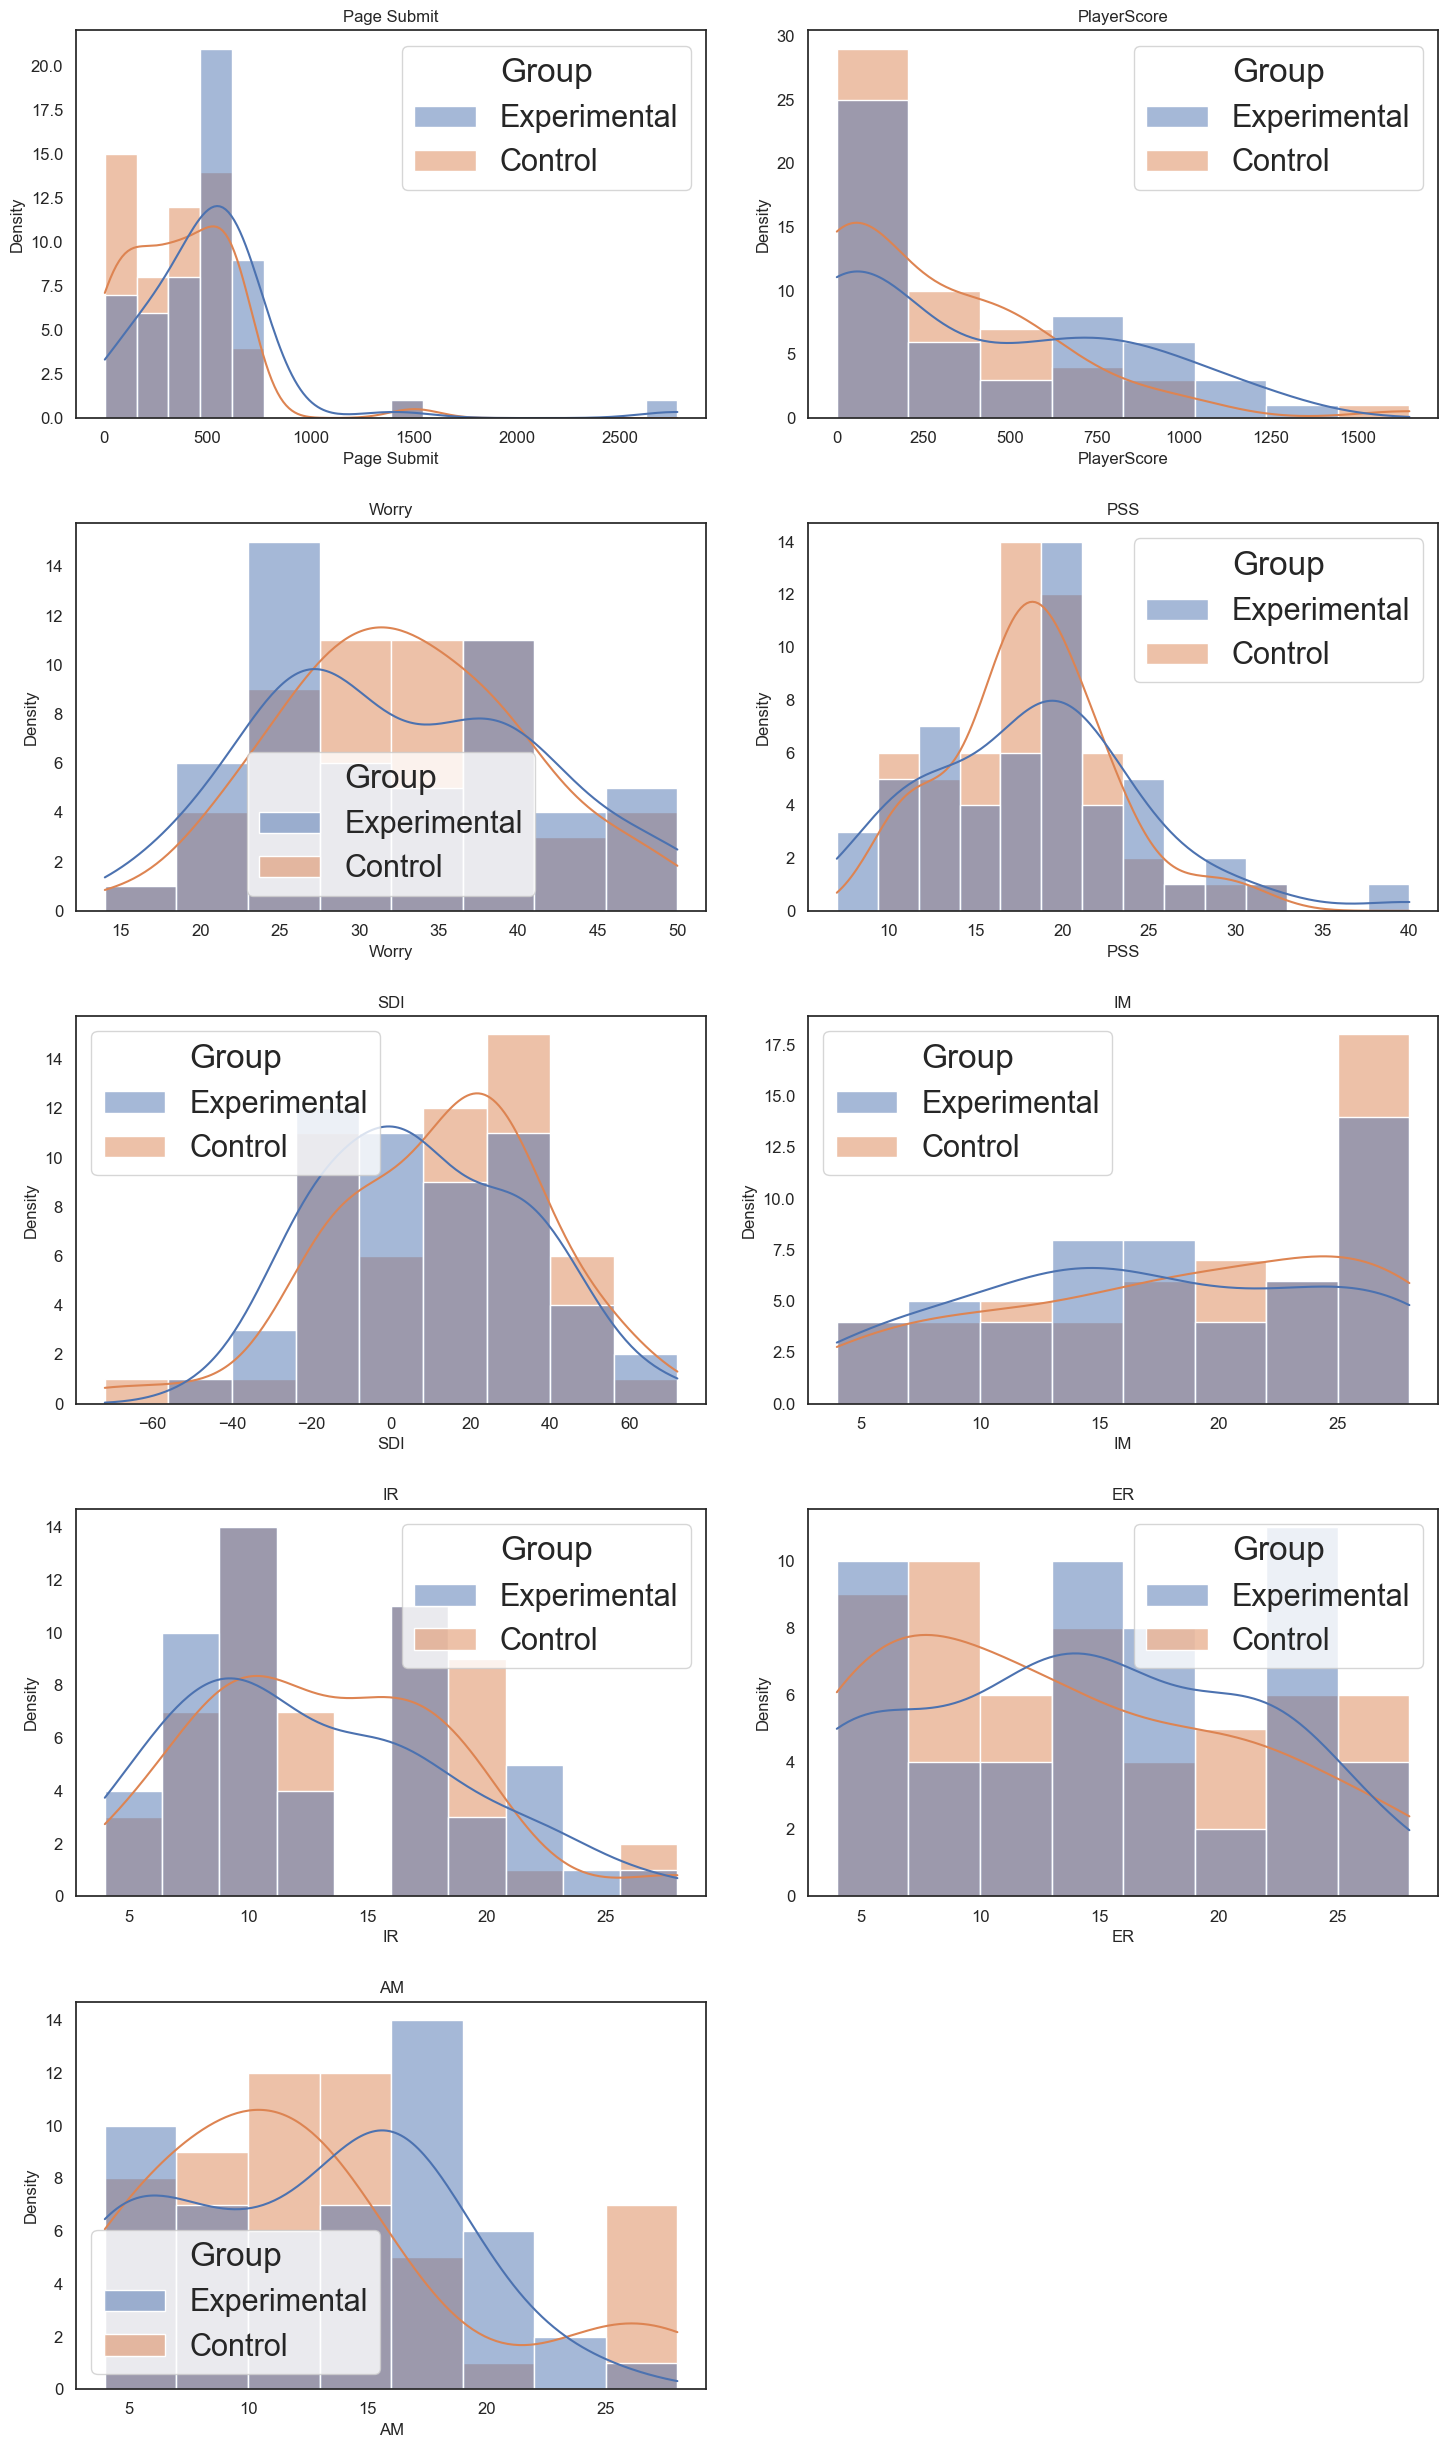

In [19]:
# Plot distributions of all numeric variables between groups
def btwn_groups_plots(data, subplots, fig_size):
    v, h = subplots[:2]
    fig, axes = plt.subplots(v, h, figsize=fig_size)
    label_size =12
    i = 0

    if v * h == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Use second level of multi-index to index columns for plotting
    data2 = data.droplevel(level=0, axis=1)

    # Only plot numeric columns
    for col in data[['Task', 'Psych', 'SIMS']].columns.get_level_values(1):
        sns.histplot(data= data2, x= col, ax=axes[i], hue= 'Group', kde= True, common_norm= True)
        axes[i].set_title(col, fontsize=label_size)
        axes[i].set_xlabel(col, fontsize=label_size)
        axes[i].set_ylabel('Density', fontsize=label_size)
        axes[i].tick_params(axis="both", labelsize=label_size)
        i += 1

    fig.delaxes(axes[-1])
    plt.tight_layout()

btwn_groups_plots(data, [len(num_cols)//2+1, 2, 1], [15, 25])

In [11]:
# Create two dataframes: separate data from each group
E_data = data[data['Metadata','Group'] == 'Experimental']
C_data = data[data['Metadata','Group'] == 'Control']

In [12]:
def within_groups_plots(data, subplots, fig_size):
    v, h = subplots[:2]
    fig, axes = plt.subplots(v, h, figsize=fig_size)
    label_size = 9
    i = 0

    if v * h == 1:
        axes = [axes]  # Convert single-axis to a list
    else:
        axes = axes.flatten()

    data2 = data.droplevel(level=0, axis=1)
    for y_col in data['Task'].columns:
        for x_col in data[['Psych', 'SIMS']].columns.get_level_values(1):
            sns.scatterplot(data= data2, x= x_col, y= y_col, hue= "Group", ax=axes[i])
            axes[i].set_title(f"{y_col} vs. {x_col}", fontsize=label_size)
            axes[i].set_xlabel(x_col, fontsize=label_size)
            axes[i].set_ylabel(y_col, fontsize=label_size)
            axes[i].tick_params(axis="both", labelsize=label_size)
            axes[i].legend(fontsize= label_size)
            i += 1

    if len(subplots) == 3:
        extra_axes = v * h - i
        for j in range(extra_axes):
            plt.delaxes(axes[i + j])
            
    plt.tight_layout()

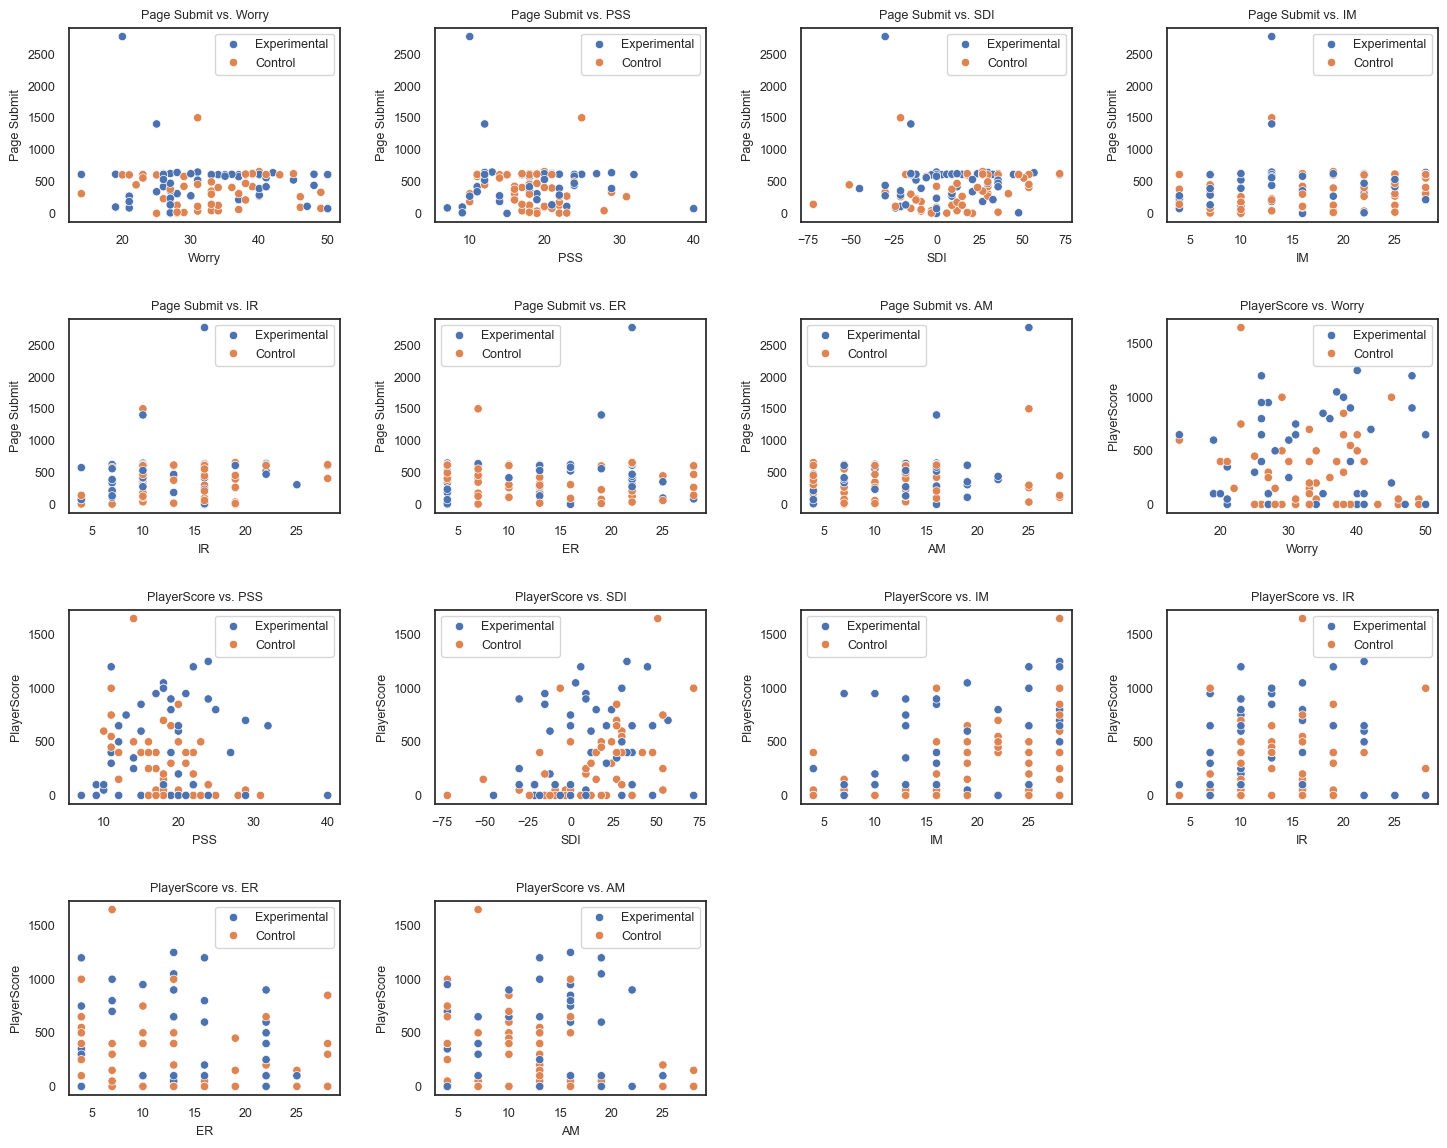

In [13]:
# Plot experimental group data
within_groups_plots(data, [4, 4, 1], [15, 12])

In [49]:
# Calculate spearman correlations between variables
spearman_E = E_data.droplevel(level=0, axis=1).corr(method= 'spearman').iloc[2:, :2]
spearman_C = C_data.droplevel(level=0, axis=1).corr(method= 'spearman').iloc[2:, :2]

/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_14981/4250275342.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  spearman_E = E_data.droplevel(level=0, axis=1).corr(method= 'spearman').iloc[2:, :2]
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_14981/4250275342.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  spearman_C = C_data.droplevel(level=0, axis=1).corr(method= 'spearman').iloc[2:, :2]


In [50]:
# Spearman's correlations for the experiemental group
spearman_E

,Page Submit,PlayerScore
Worry,0.062499,0.056313
PSS,0.131130,0.045672
SDI,0.231255,0.248644
IM,0.377417,0.372331
IR,0.301831,0.232107
ER,-0.035753,-0.131585
AM,0.163161,0.200820


In [51]:
# Spearman's correlations for the control group
spearman_C

,Page Submit,PlayerScore
Worry,0.155498,-0.005944
PSS,-0.275032,-0.358012
SDI,0.389738,0.513500
IM,0.413886,0.523018
IR,0.214045,0.214155
ER,-0.200278,-0.124097
AM,-0.035932,-0.170281


<Axes: xlabel='PlayerScore'>

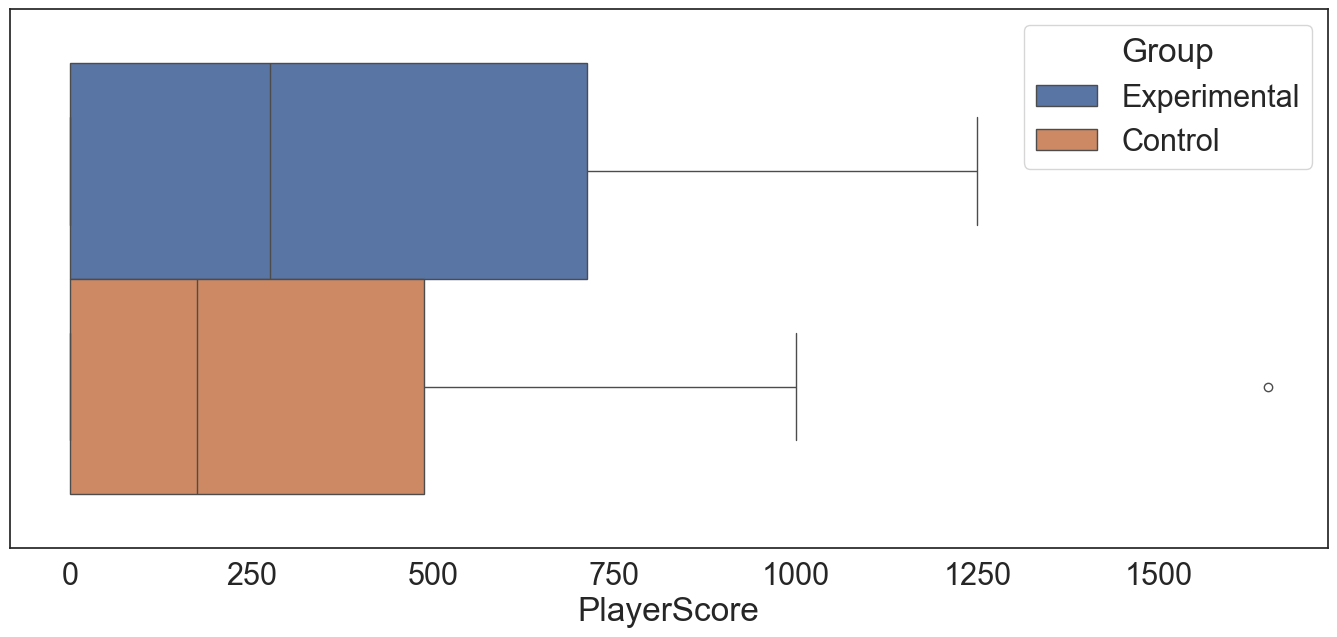

In [ ]:
# Plot distributions of player score between groups
sns.boxplot(data=data.droplevel(level=0, axis=1), x="PlayerScore", hue="Group")

<Axes: xlabel='Page Submit'>

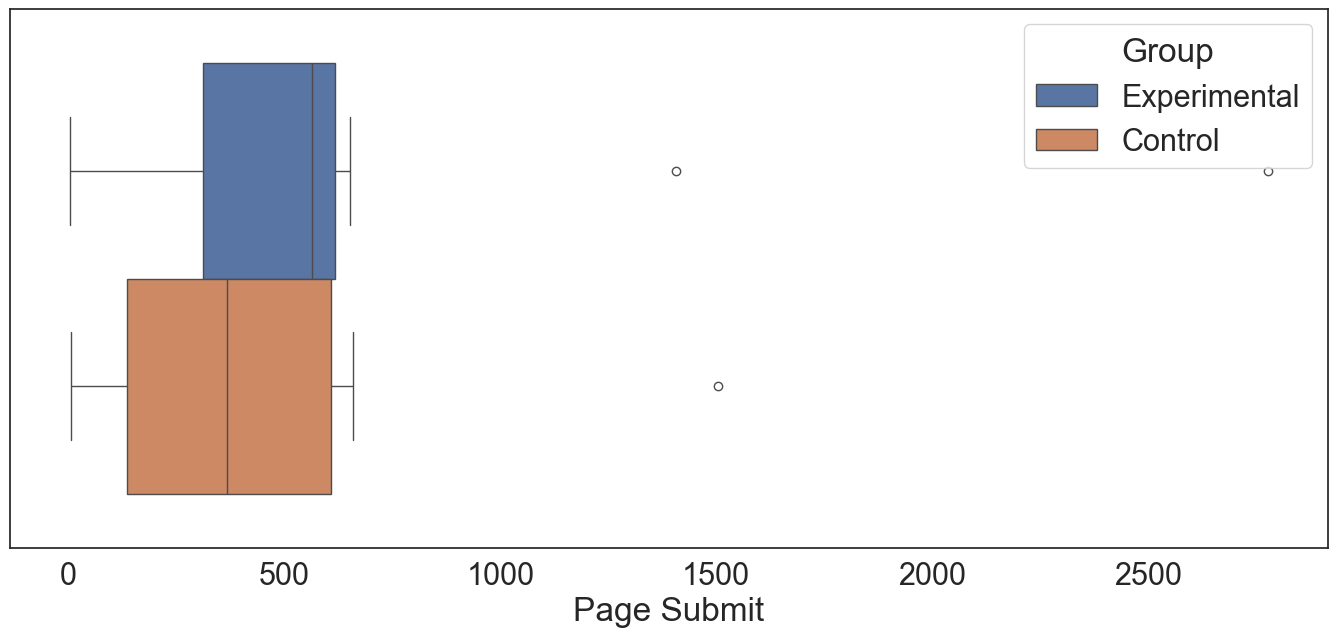

In [ ]:
# Plot distributions of quitting time between groups
sns.boxplot(data=data.droplevel(level=0, axis=1), x="Page Submit", hue="Group")

Text(0.5, 0, 'Survey Score')

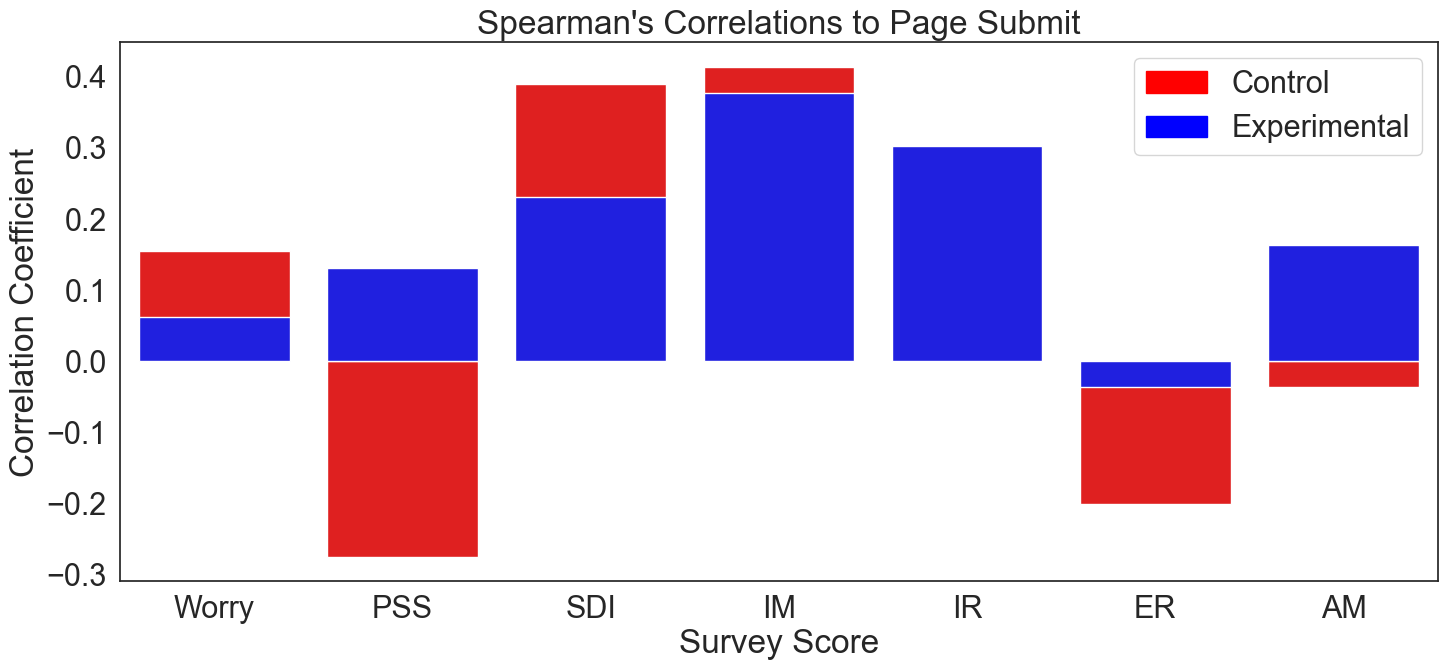

In [67]:
# Plot correlations to quitting time of all survey results
C_bar = sns.barplot(data= spearman_C["Page Submit"], color= 'red')
C_patch = mpatches.Patch(color='red', label='Control')
E_bar = sns.barplot(data= spearman_E["Page Submit"], color= 'blue')
E_patch = mpatches.Patch(color='blue', label='Experimental')
plt.legend(handles= [C_patch, E_patch])
plt.title("Spearman's Correlations to Page Submit")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Survey Score")

Text(0.5, 0, 'Survey Score')

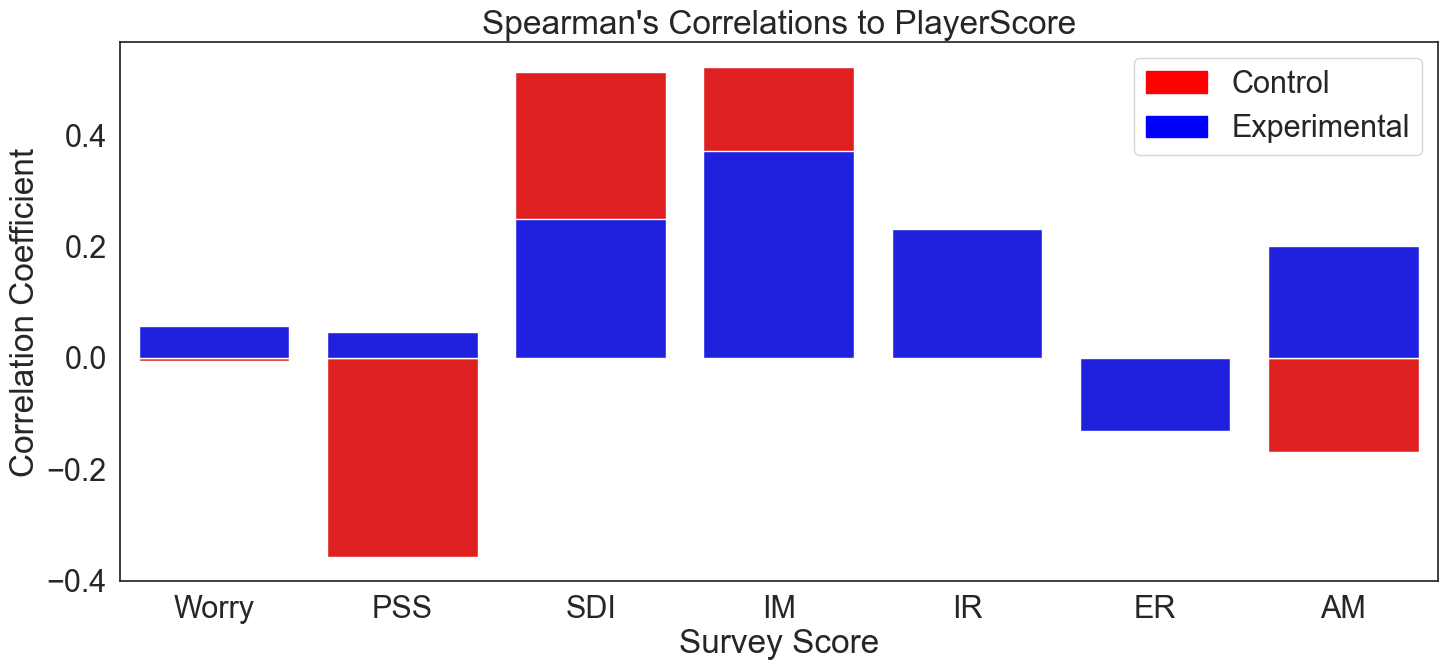

In [68]:
# Plot correlations to score of all survey results
C_bar = sns.barplot(data= spearman_C["PlayerScore"], color= 'red')
C_patch = mpatches.Patch(color='red', label='Control')
E_bar = sns.barplot(data= spearman_E["PlayerScore"], color= 'blue')
E_patch = mpatches.Patch(color='blue', label='Experimental')
plt.legend(handles= [C_patch, E_patch])
plt.title("Spearman's Correlations to PlayerScore")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Survey Score")

In [ ]:
# means = data.groupby(by= "Group").mean()

# def plot_spearman(data):
#     fig, axes = plt.subplots(1, 2, figsize=(20, 10))
#     label_size = 9

#     for i, y_col in enumerate(['PlayerScore', 'Page Submit']):
#         sns.lineplot(data=means, x="Group", y=col)
#         axes[i].set_title(f"{y_col} Means", fontsize=label_size)
#         axes[i].set_xlabel("Group", fontsize=label_size)
#         axes[i].set_ylabel(y_col, fontsize=label_size)
#         axes[i].tick_params(axis="both", labelsize=label_size)
#     plt.tight_layout()

# plot_means(means)


In [34]:
demographic_info

,Q_Age,Q_Gender,Q_Ethn,Q_Income,Q_FinSec
1,18-21 years old,Man,Hispanic/Latino,Low income/Lower class,Somewhat Secure
2,18-21 years old,Non-binary,"White or European American,Hispanic/Latino",Low income/Lower class,Not very secure
3,18-21 years old,Woman,East Asian,Comfortable income/Middle class,Secure
4,18-21 years old,Man,"White or European American,East Asian",Comfortable income/Middle class,Secure
5,22-25 years old,Man,White or European American,Comfortable income/Middle class,Secure
...,...,...,...,...,...
103,31-40 years old,Woman,Hispanic/Latino,Low income/Lower class,Not very secure
104,22-25 years old,Man,Other,Low income/Lower class,Not very secure
105,18-21 years old,Woman,East Asian,Comfortable income/Middle class,Somewhat Secure
106,18-21 years old,Woman,East Asian,Low income/Lower class,Not very secure


Demographic Information

Text(0.5, 1.0, 'Participant Gender')

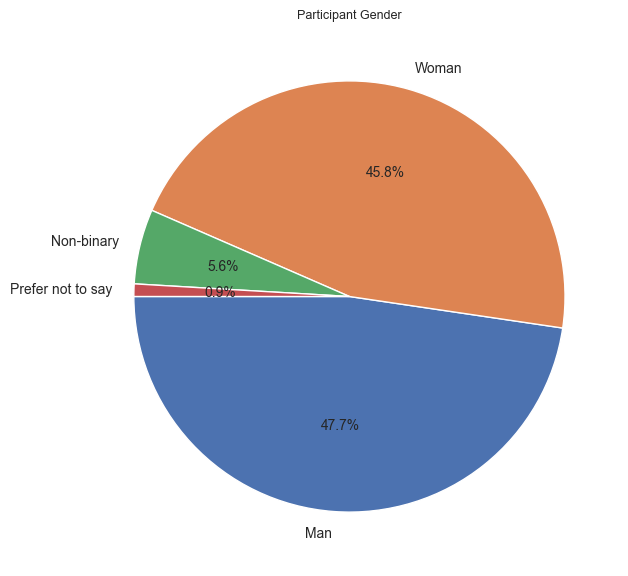

In [36]:
# Gender
labelsize = 9
fig, ax = plt.subplots()
ax.pie(demographic_info["Q_Gender"].value_counts(), labels= demographic_info["Q_Gender"].value_counts().index, startangle=180, autopct='%1.1f%%', textprops= {"fontsize": 10})
ax.set_title("Participant Gender", fontsize= labelsize)

Text(0.5, 1.0, 'Participant Age')

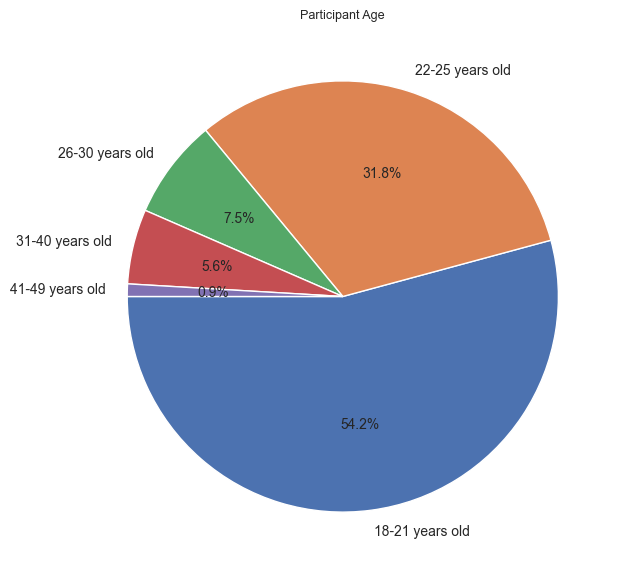

In [37]:
# Age
labelsize = 9
fig, ax = plt.subplots()
ax.pie(demographic_info["Q_Age"].value_counts(), labels= demographic_info["Q_Age"].value_counts().index, startangle=180, autopct='%1.1f%%', textprops= {"fontsize": 10})
ax.set_title("Participant Age", fontsize= labelsize)

Text(0.5, 1.0, 'Participant Ethnicity')

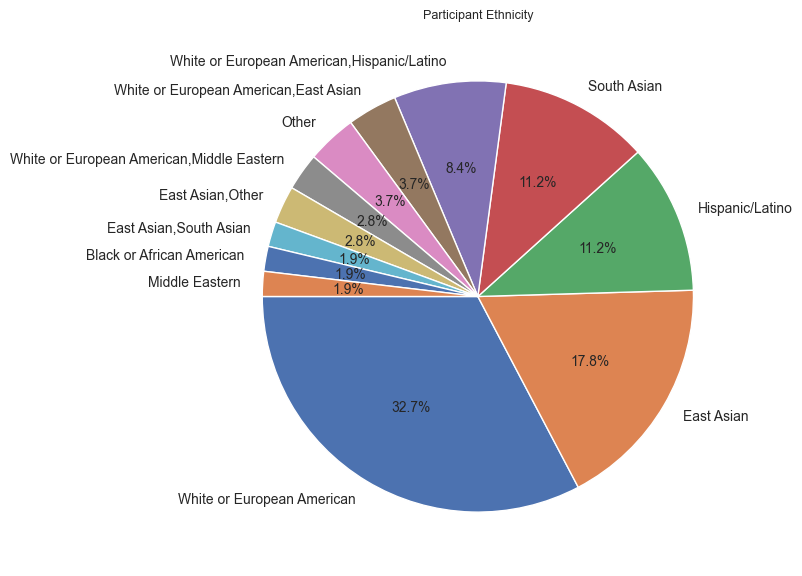

In [38]:
# Ethnicity
labelsize = 9
fig, ax = plt.subplots()
ax.pie(demographic_info["Q_Ethn"].value_counts(), labels= demographic_info["Q_Ethn"].value_counts().index, startangle=180, autopct='%1.1f%%', textprops= {"fontsize": 10})
ax.set_title("Participant Ethnicity", fontsize= labelsize)

Text(0.5, 1.0, 'Participant Income')

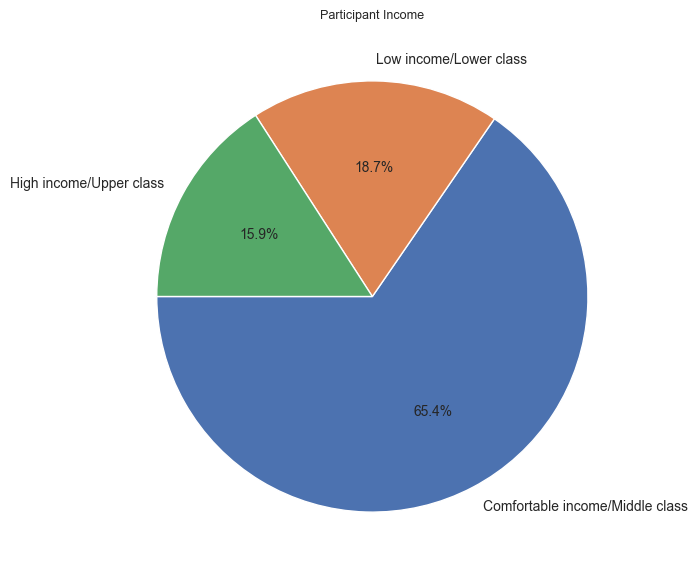

In [39]:
# Income
labelsize = 9
fig, ax = plt.subplots()
ax.pie(demographic_info["Q_Income"].value_counts(), labels= demographic_info["Q_Income"].value_counts().index, startangle=180, autopct='%1.1f%%', textprops= {"fontsize": 10})
ax.set_title("Participant Income", fontsize= labelsize)